### Load and prepare data for training
1. **Load**: load the dataframe containing the image url and the labels of each image.
2. **Clean**: clean the dataframe from images with unreadable encoding, with empty labels, or that raises PIL errors.
3. **Split and save**: split the dataframe into train, test and validation and save.


In [1]:
import pandas as pd
import urllib.parse
import os
from tqdm import tqdm
import help_functions as hf
import PIL
from PIL import Image
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../')
from config import FILES_ANNOTATED_PATH, EVALUATION_PATH
tqdm.pandas()

Using TensorFlow backend.


### 1. Load
Load the dataframe (coming from Francesco) containing the image url and the labels of each image.

In [78]:
# Input files --> update this to the latest data file generated with Francesco's taxonomy in get_labels.ipynb
# LABELS_PATH = 'data/commonswiki-221218-files-hierarchical-labels.json.bz2'
LABELS_PATH = FILES_ANNOTATED_PATH

# Output files --> choose 
CLEANED_LABELS_PATH = 'data/commonswiki-230412-clean-labels.json.bz2'
SPLIT_DATA_PATH = 'data/split_data_230412'

labels = pd.read_parquet(LABELS_PATH).rename(columns={'labels_pred': 'labels'})
print(labels.shape)
labels.head()

(3891446, 5)


,id,title,url,categories,labels
0,80902489,"""A Gathering of Court Women"", Folio from the D...",c/c1/%22A_Gathering_of_Court_Women%22%2C_Folio...,"[Department of Islamic Art, Metropolitan Museu...","[Art, Culture]"
1,53631642,"""Akdeniz"" - Aliağa, 2016.jpg",f/f8/%22Akdeniz%22_-_Alia%C4%9Fa%2C_2016.jpg,"[Akdeniz (ship, 1955), Aliağa ship-breaking yard]",[]
2,74785910,"""Carnevale di Torino"". Felice Cerruti - f.lli ...",1/13/%22Carnevale_di_Torino%22._Felice_Cerruti...,"[Felice Cerruti Bauduc, Victor Emmanuel II of ...","[Culture, Society, People, Places, Art]"
3,14890941,"""Escena de playa con figura"".jpg",c/c2/%22Escena_de_playa_con_figura%22.jpg,"[Pedro Lira, People with dogs in art]","[Art, People, Culture, Society]"
4,17828296,"""Florero con plátanos, limones y libros"", Juan...",d/da/%22Florero_con_pl%C3%A1tanos%2C_limones_y...,"[Works by Juan de Echevarría, Still-life paint...","[Art, Culture]"


Remove the data that is used in validation and test of the heuristics.

In [79]:
EVALUATION_PATH = '../../data/evaluation/'
held_out_test = pd.read_parquet(EVALUATION_PATH + "annotated_test.parquet")
held_out_val = pd.read_parquet(EVALUATION_PATH + "annotated_validation.parquet")
held_out_set = pd.concat([held_out_test, held_out_val])
print(held_out_set.shape)
held_out_set.head()

(1087, 5)


,title,id,url,categories,labels
0,Homemade minestrone.jpg,12565901,https://upload.wikimedia.org/wikipedia/commons...,"[Minestrone, Plan views of food, Grated cheese...","[Culture, Food]"
7,Abrazo del Estrecho B&N.jpg,20853818,https://upload.wikimedia.org/wikipedia/commons...,"[Federico Errázuriz Echaurren, Julio Argentino...","[Transportation, Events, People, Society]"
8,Trewavasia carinata.JPG,15084421,https://upload.wikimedia.org/wikipedia/commons...,"[Pycnodontiformes fossils, Trewavasia]","[STEM, Nature, Geology & Fossils]"
10,Icefields Parkway-01.jpg,12424009,https://upload.wikimedia.org/wikipedia/commons...,[Icefields Parkway],"[Places, Landscapes, STEM, Geology & Fossils]"
13,E-2 10 TL arka.jpg,18629102,https://upload.wikimedia.org/wikipedia/commons...,"[Banknotes of Turkey, Banknotes with a face va...",[]


In [80]:
labels = labels[~labels['title'].isin(held_out_set.title.values)]
print(labels.shape)
labels.head()

(3890362, 5)


,id,title,url,categories,labels
0,80902489,"""A Gathering of Court Women"", Folio from the D...",c/c1/%22A_Gathering_of_Court_Women%22%2C_Folio...,"[Department of Islamic Art, Metropolitan Museu...","[Art, Culture]"
1,53631642,"""Akdeniz"" - Aliağa, 2016.jpg",f/f8/%22Akdeniz%22_-_Alia%C4%9Fa%2C_2016.jpg,"[Akdeniz (ship, 1955), Aliağa ship-breaking yard]",[]
2,74785910,"""Carnevale di Torino"". Felice Cerruti - f.lli ...",1/13/%22Carnevale_di_Torino%22._Felice_Cerruti...,"[Felice Cerruti Bauduc, Victor Emmanuel II of ...","[Culture, Society, People, Places, Art]"
3,14890941,"""Escena de playa con figura"".jpg",c/c2/%22Escena_de_playa_con_figura%22.jpg,"[Pedro Lira, People with dogs in art]","[Art, People, Culture, Society]"
4,17828296,"""Florero con plátanos, limones y libros"", Juan...",d/da/%22Florero_con_pl%C3%A1tanos%2C_limones_y...,"[Works by Juan de Echevarría, Still-life paint...","[Art, Culture]"


### 2. Clean
Clean the dataframe from images with bad encoding, with empty labels or that give errors. 

In [81]:
# ------------- Only keep files that can be opened (eliminate encoding problems)

# With this encoded url, only 190k images aren't found, while with "url" 790k aren't found
labels['url'] = labels['url'].progress_apply(lambda encoded_filename : urllib.parse.unquote(encoded_filename).encode().decode('unicode-escape'))
print('Done changing encoding')
labels['can_be_opened'] = labels['url'].progress_apply(lambda url : os.path.isfile('/scratch/WIT_Dataset/images/' + url))
print(f'Total number of files: {labels.shape[0]}.')

labels_clean = labels.loc[labels.can_be_opened == True].reset_index(drop=True)

print(f'Total number of files that can be opened: {labels_clean.shape[0]}.')
print(labels_clean.shape)

100%|██████████| 3890362/3890362 [00:12<00:00, 306857.85it/s]


Done changing encoding


100%|██████████| 3890362/3890362 [00:19<00:00, 200723.57it/s]


Total number of files: 3890362.
Total number of files that can be opened: 3515352.
(3515352, 6)


In [82]:
# ------------- Only keep files in jpg format (eliminate problem of png and webp format)
labels_jpg = labels_clean.loc[labels_clean.url.str.endswith(('.jpg', '.JPG', '.Jpg'))]
print(f'{labels_jpg.shape[0]} images of type .jpg')

3093165 images of type .jpg


**Extra cleaning** (not necessary if only .jpg images are used). When running `model.fit()`, it fails with the `PIL.UnidentifiedImageError` exception error for some images. It's mostly images from format .webp, but there are also some .png images. Remove them from the dataset. Example: `!ls /scratch/WIT_Dataset/images/d/d7/World_Scout_Jamboree_-_Punch_cartoon_-_Project_Gutenberg_eText_16628.png` works. but `PIL.Image.open('/scratch/WIT_Dataset/images/d/d7/World_Scout_Jamboree_-_Punch_cartoon_-_Project_Gutenberg_eText_16628.png')` fails.

If you only use .jpg files, you can skip this (can take up to 10 hours on the DLAB 039 cluster).

In [ ]:
# # ------------- Extra cleaning --> Not necessary if only .jpg files are used.

# for index, row in tqdm(labels_jpg.iterrows(), total=labels_jpg.shape[0]):
#     try:
#         img = Image.open('/scratch/WIT_Dataset/images/' + row.url)
#     except PIL.UnidentifiedImageError:
#         print(row.url)
#         labels_jpg.at[index, 'can_be_opened'] = False
#     except Exception as e:
#         print(e)
#         labels_jpg.at[index, 'can_be_opened'] = False

# openable_labels = labels_jpg.loc[labels_jpg.can_be_opened == True]

# openable_labels.to_json(CLEANED_LABELS_PATH)

Remove images whose labels are empty

In [83]:
labels = labels_jpg.loc[labels_jpg['labels'].str.len() != 0]
labels = labels.drop(columns=['can_be_opened'])
print(labels.shape)
labels['labels'] = labels.apply(lambda x: list(x.labels), axis=1) # otherwise the labels column will be a list of lists
labels.head()

(2832911, 5)


,id,title,url,categories,labels
1,74785910,"""Carnevale di Torino"". Felice Cerruti - f.lli ...","1/13/""Carnevale_di_Torino""._Felice_Cerruti_-_f...","[Felice Cerruti Bauduc, Victor Emmanuel II of ...","[Culture, Society, People, Places, Art]"
2,14890941,"""Escena de playa con figura"".jpg","c/c2/""Escena_de_playa_con_figura"".jpg","[Pedro Lira, People with dogs in art]","[Art, People, Culture, Society]"
4,33628123,"""Keep FDA Off The Farm"" (FDA 140) (8205957369)...","b/bc/""Keep_FDA_Off_The_Farm""_(FDA_140)_(820595...","[Food and Drug Administration (United States),...","[Nature, Society, People, STEM]"
5,17073242,"""Mary Holiday"" - NARA - 559051.jpg","0/02/""Mary_Holiday""_-_NARA_-_559051.jpg","[Art of the United States, Harmon Foundation, ...","[People, Society]"
6,5259480,"""The End of the 'Forty Five' Rebellion"".jpg","c/c7/""The_End_of_the_'Forty_Five'_Rebellion"".jpg","[Battle of Culloden, 1882 engravings, Wounded ...","[History, People, Culture, Society, Art]"


### 3. Split and save
Split the dataframe into train, test and validation and save.

In [86]:
# Sample images
samples = labels.sample(n=1_000_000)

train_df, rest_df = train_test_split(samples, test_size=0.3, random_state=0)
val_df, test_df = train_test_split(rest_df, test_size=0.5, random_state=0)
val_df, thresh_df = train_test_split(val_df, test_size=0.5, random_state=0)
print(f'Train set: {train_df.shape[0]} images ({100 * train_df.shape[0] / samples.shape[0]:.2f}%)')
print(f'Test set:  {test_df.shape[0]}  images ({100 * test_df.shape[0] / samples.shape[0]:.2f}%)')
print(f'Val set:  {val_df.shape[0]}  images ({100 * val_df.shape[0] / samples.shape[0]:.2f}%)')
print(f'Thresh set:  {val_df.shape[0]}  images ({100 * thresh_df.shape[0] / samples.shape[0]:.2f}%)')

Train set: 700000 images (70.00%)
Test set:  150000  images (15.00%)
Val set:  75000  images (7.50%)
Thresh set:  75000  images (7.50%)


Found 700000 non-validated image filenames belonging to 28 classes.
Found 150000 non-validated image filenames belonging to 28 classes.
Found 75000 non-validated image filenames belonging to 28 classes.
Found 75000 non-validated image filenames belonging to 28 classes.


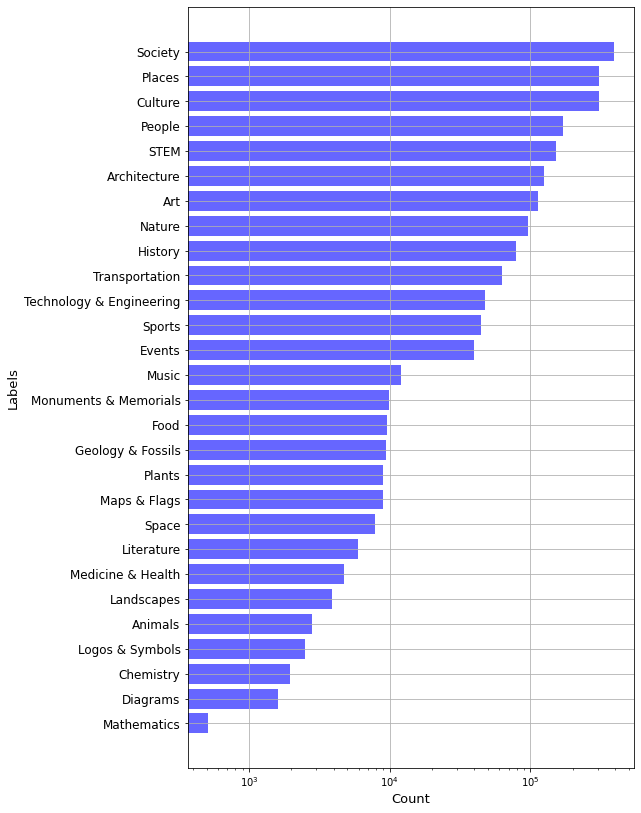

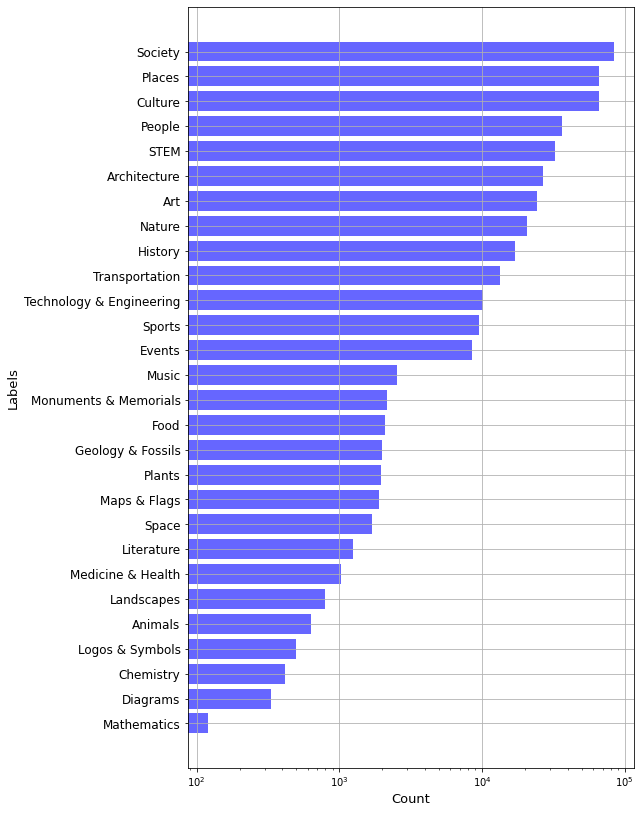

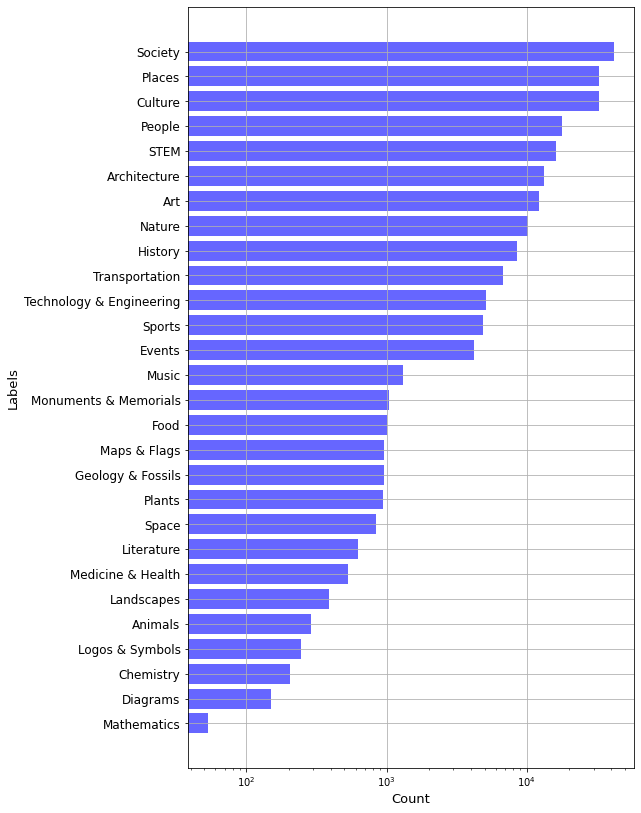

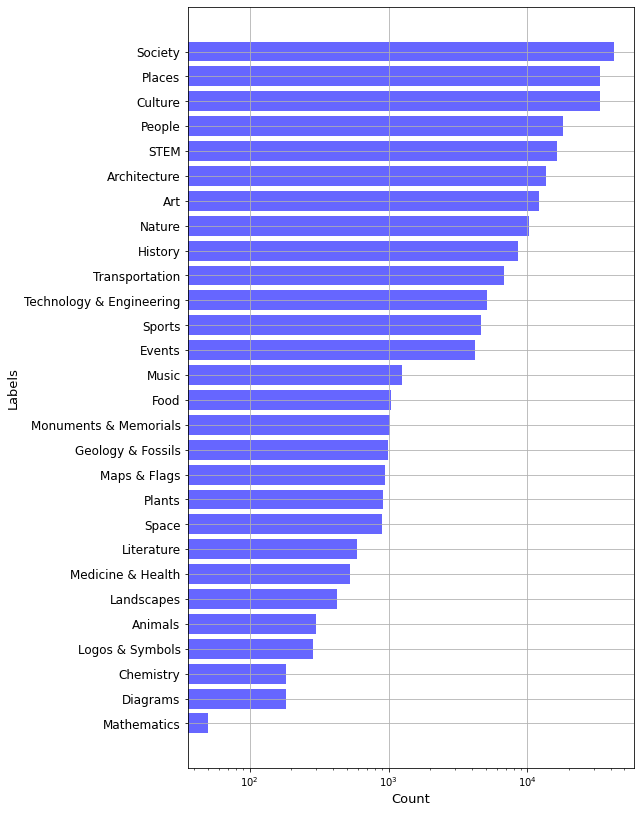

In [89]:
os.mkdir(SPLIT_DATA_PATH)
hf.plot_distribution(dataframe=train_df, filename=SPLIT_DATA_PATH + '/train_distribution.png')
hf.plot_distribution(dataframe=test_df, filename=SPLIT_DATA_PATH + '/test_distribution.png')
hf.plot_distribution(dataframe=val_df, filename=SPLIT_DATA_PATH + '/val_distribution.png')
hf.plot_distribution(dataframe=thresh_df, filename=SPLIT_DATA_PATH + '/thresh_distribution.png')

train_df.to_json(f'{SPLIT_DATA_PATH}/train_df.json.bz2', compression='bz2')
test_df.to_json(f'{SPLIT_DATA_PATH}/test_df.json.bz2', compression='bz2')
val_df.to_json(f'{SPLIT_DATA_PATH}/val_df.json.bz2', compression='bz2')
thresh_df.to_json(f'{SPLIT_DATA_PATH}/thresh_df.json.bz2', compression='bz2')